Copyright **`(c)`** 2022 Giovanni Squillero `<squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  


# Lab 3: Policy Search

## Task

Write agents able to play [*Nim*](https://en.wikipedia.org/wiki/Nim), with an arbitrary number of rows and an upper bound $k$ on the number of objects that can be removed in a turn (a.k.a., *subtraction game*).

The player **taking the last object wins**.

* Task3.1: An agent using fixed rules based on *nim-sum* (i.e., an *expert system*)
* Task3.2: An agent using evolved rules
* Task3.3: An agent using minmax
* Task3.4: An agent using reinforcement learning

## Instructions

* Create the directory `lab3` inside the course repo 
* Put a `README.md` and your solution (all the files, code and auxiliary data if needed)

## Notes

* Working in group is not only allowed, but recommended (see: [Ubuntu](https://en.wikipedia.org/wiki/Ubuntu_philosophy) and [Cooperative Learning](https://files.eric.ed.gov/fulltext/EJ1096789.pdf)). Collaborations must be explicitly declared in the `README.md`.
* [Yanking](https://www.emacswiki.org/emacs/KillingAndYanking) from the internet is allowed, but sources must be explicitly declared in the `README.md`.

## Deadlines ([AoE](https://en.wikipedia.org/wiki/Anywhere_on_Earth))

* Sunday, December 4th for Task3.1 and Task3.2
* Sunday, December 11th for Task3.3 and Task3.4
* Sunday, December 18th for all reviews

In [34]:
# this section was provided by Professor Squillero

import logging
from collections import namedtuple
import random
from typing import Callable
from copy import deepcopy
from itertools import accumulate
from operator import xor

## The *Nim* and *Nimply* classes

Namedtuple that contains the instructions for a single move, it is the results of a single call of a "strategy" function.

In [35]:
# this section was provided by Professor Squillero

Nimply = namedtuple("Nimply", "row, num_objects")

The Nim class contains all methods and properties to instantiate a Nim game, and the nimming function to handle a ply and modify the board accordingly.

In [36]:
# this section was provided by Professor Squillero

class Nim:
    def __init__(self, num_rows: int, k: int = None) -> None:
        self._rows = [i * 2 + 1 for i in range(num_rows)]
        self._k = k

    def __bool__(self):
        return sum(self._rows) > 0

    def __str__(self):
        return "<" + " ".join(str(_) for _ in self._rows) + ">"

    @property
    def rows(self) -> tuple:
        return tuple(self._rows)

    @property
    def k(self) -> int:
        return self._k

    def nimming(self, ply: Nimply) -> None:
        row, num_objects = ply
        assert self._rows[row] >= num_objects
        assert self._k is None or num_objects <= self._k
        self._rows[row] -= num_objects

## Sample (and silly) startegies 

A random strategy, making random moves.

In [37]:
# this section was provided by Professor Squillero
logging.getLogger().setLevel(logging.INFO)

def pure_random(state: Nim) -> Nimply:
    row = random.choice([r for r, c in enumerate(state.rows) if c > 0])
    num_objects = random.randint(1, state.rows[row])
    return Nimply(row, num_objects)

A simple rule-based strategy that improves over the random making the winning move in case the possibiliy arises.

In [38]:
# this section was provided by Professor Squillero

def gabriele(state: Nim) -> Nimply:
    """Pick always the maximum possible number of the lowest row"""
    possible_moves = [(r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1)]
    return Nimply(*max(possible_moves, key=lambda m: (-m[0], m[1])))

Code for verifying the nim_sum value and a function that analyzes the conditions of the boards and outputs a dictionary with some info, that a strategy-making function may use.

In [39]:
def nim_sum(state: Nim) -> int:
    *_, result = accumulate(state.rows, xor)
    return result


def cook_status(state: Nim) -> dict:
    cooked = dict()
    cooked["possible_moves"] = [
        (r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1) if state.k is None or o <= state.k
    ]
    cooked["active_rows_number"] = sum(o > 0 for o in state.rows)
    cooked["shortest_row"] = min((x for x in enumerate(state.rows) if x[1] > 0), key=lambda y: y[1])[0]
    cooked["longest_row"] = max((x for x in enumerate(state.rows)), key=lambda y: y[1])[0]
    cooked["nim_sum"] = nim_sum(state)

    brute_force = list()
    for m in cooked["possible_moves"]:
        tmp = deepcopy(state)
        tmp.nimming(m)
        brute_force.append((m, nim_sum(tmp)))
    cooked["brute_force"] = brute_force

    return cooked

Optimal stratgy that relies on nim sum computation.

In [40]:
# this section was provided by Professor Squillero

def optimal_strategy(state: Nim) -> Nimply:
    data = cook_status(state)
    return next((bf for bf in data["brute_force"] if bf[1] == 0), random.choice(data["brute_force"]))[0]

Random strategy enclosed in the make strategy method.

In [41]:
# this section was provided by Professor Squillero

def make_strategy(genome: dict) -> Callable:
    def evolvable(state: Nim) -> Nimply:
        data = cook_status(state)

        if random.random() < genome["p"]:
            ply = Nimply(data["shortest_row"], random.randint(1, state.rows[data["shortest_row"]]))
        else:
            ply = Nimply(data["longest_row"], random.randint(1, state.rows[data["longest_row"]]))

        return ply

    return evolvable

Evaluate function to compare two strategies one against the other.

In [42]:

def evaluate(strategy1: Callable, strategy2: Callable, size=11, num_matches=100) -> float:
    players = (strategy1, strategy2)
    won = 0

    for m in range(num_matches):
        nim = Nim(size)
        player = 0
        while nim:
            ply = players[player](nim)
            nim.nimming(ply)
            player = 1 - player
        if player == 1:
            won += 1
    return won / num_matches

Function to show visually the steps of the game.

In [43]:
def show_game(strategy1: Callable, strategy2: Callable, size=10) -> None:
    players = (strategy1, strategy2)
    won = 0

    logging.getLogger().setLevel(logging.DEBUG)

    nim = Nim(size)
    logging.debug(f"status: Initial board -> {nim}")
    player = 0
    while nim:
        ply = players[player](nim)
        nim.nimming(ply)
        logging.debug(f"status: After player {player} -> {nim}")
        player = 1 - player
    winner = 1 - player
    logging.info(f"status: Player {winner} won!")
    

In [44]:
logging.info(f"'gabriele' strategy vs. pure random  -> {evaluate(gabriele, pure_random)}")
show_game(optimal_strategy, optimal_strategy)

INFO:root:'gabriele' strategy vs. pure random  -> 0.82
DEBUG:root:status: Initial board -> <1 3 5 7 9 11 13 15 17 19>
DEBUG:root:status: After player 0 -> <1 1 5 7 9 11 13 15 17 19>
DEBUG:root:status: After player 1 -> <1 1 5 7 9 11 13 15 2 19>
DEBUG:root:status: After player 0 -> <1 1 5 7 9 11 13 15 2 0>
DEBUG:root:status: After player 1 -> <1 1 5 7 9 11 6 15 2 0>
DEBUG:root:status: After player 0 -> <1 1 5 7 2 11 6 15 2 0>
DEBUG:root:status: After player 1 -> <1 1 3 7 2 11 6 15 2 0>
DEBUG:root:status: After player 0 -> <1 1 3 1 2 11 6 15 2 0>
DEBUG:root:status: After player 1 -> <1 1 3 1 2 11 6 0 2 0>
DEBUG:root:status: After player 0 -> <1 1 3 1 2 4 6 0 2 0>
DEBUG:root:status: After player 1 -> <1 1 3 1 2 4 6 0 0 0>
DEBUG:root:status: After player 0 -> <1 1 1 1 2 4 6 0 0 0>
DEBUG:root:status: After player 1 -> <1 1 1 1 2 4 1 0 0 0>
DEBUG:root:status: After player 0 -> <1 1 1 1 2 3 1 0 0 0>
DEBUG:root:status: After player 1 -> <1 0 1 1 2 3 1 0 0 0>
DEBUG:root:status: After player 0 -

## 3.0 Agent with hard-coded rules
Sub-optimal agent implementing an expert system through hard-coded rules, which aims to consistently defeat the pure-random strategy and the "gabriele" strategy, but will probably be consistently defeated by the optimal strategy and nim sum.
I changed the terminology because speaking about hard-coded rules the term genome seems out of place, and parameters seems more appropriate.

In [45]:
def hard_coded(params: dict) -> Callable:
    def evolvable(state: Nim) -> Nimply:
        data = cook_status(state)

        if data["active_rows_number"] > 2: # if there are more than two active rows, empties one row
            ply = Nimply(data["longest_row"], 1)
        elif data["active_rows_number"] == 2: # if there are two active rows, leaves one element in the longest row
            ply = Nimply(data["longest_row"], state.rows[data["longest_row"]]-1 if state.rows[data["longest_row"]]>=2 else state.rows[data["longest_row"]])
        else:
            ply = Nimply(data["longest_row"], state.rows[data["longest_row"]])
        return ply

    return evolvable

In [46]:
params_empty = dict()
logging.info(f" Hard coded strategy vs. 'gabriele' -> {evaluate(hard_coded(params_empty), gabriele)}")

INFO:root: Hard coded strategy vs. 'gabriele' -> 1.0


## 3.1 Agent implementing nim sum, or Optimal Strategy
Sub-optimal agent implementing an expert system through hard-coded rules, which aims to consistently defeat the pure-random strategy and the "gabriele" strategy, but will probably be consistently defeated by the optimal strategy and nim sum.
I changed the terminology because speaking about hard-coded rules the term genome seems out of place, and parameters seems more appropriate.

In [47]:
def nim_sum_strategy(state: Nim) -> Nimply:
    data = cook_status(state)
    params_empty = dict()
    nim_sum_positive_moves = [move for move in data["brute_force"] if move[1] == 0]
    if len(nim_sum_positive_moves) > 0:
        ply = random.choice(nim_sum_positive_moves)[0]
    else:
        if data["active_rows_number"] > 2: # if there are more than two active rows, empties one row
            ply = Nimply(data["longest_row"], 1)
        elif data["active_rows_number"] == 2: # if there are two active rows, leaves one element in the longest row
            ply = Nimply(data["longest_row"], state.rows[data["longest_row"]]-1 if state.rows[data["longest_row"]]>=2 else state.rows[data["longest_row"]])
        else:
            ply = Nimply(data["longest_row"], state.rows[data["longest_row"]])
    return ply

params_empty = dict()
logging.info(f" Optimal strategy w/ nim sum vs. Hard Coded -> {evaluate(nim_sum_strategy, hard_coded(params_empty))}")
logging.info(f" Optimal strategy w/ nim sum vs. previous optimal strategy -> {evaluate(nim_sum_strategy, optimal_strategy)}")
logging.info(f" Previous optimal strategy vs. Optimal strategy w/ nim sum -> {evaluate(optimal_strategy, nim_sum_strategy)}")


INFO:root: Optimal strategy w/ nim sum vs. Hard Coded -> 1.0
INFO:root: Optimal strategy w/ nim sum vs. previous optimal strategy -> 1.0
INFO:root: Previous optimal strategy vs. Optimal strategy w/ nim sum -> 1.0


## 3.2 Agent with evolved rules

Sub-optimal agent implementing evolving rules through the implementation of a genetic algorithm.
This first strategy is a "placeholder" as it mimics our hard-coded expert system but sometimes proposing straight-up "suicidal" moves.
Especially in genome[2] we expect the value 1 to dominate.
Using this system we'll set up the elements of our GA.

In [48]:
def evolving_strategy(genome: list) -> Callable:
    def evolvable(state: Nim) -> Nimply:
        data = cook_status(state)
        
        # early game policy
        if genome[0] == 0 & data["active_rows_number"] > 2:
            ply = Nimply(data["longest_row"], 1)
        elif genome[0] == 1 & data["active_rows_number"] > 2:
            ply = Nimply(data["longest_row"], state.rows[data["longest_row"]])
        elif genome[0] == 2 & data["active_rows_number"] > 2:
            ply = Nimply(data["shortest_row"], state.rows[data["shortest_row"]])

        # "mid" game policy
        if genome[1] == 0 & data["active_rows_number"] == 2:
            ply = Nimply(data["longest_row"], 1)
        elif genome[1] == 1 & data["active_rows_number"] == 2:
            ply = Nimply(data["longest_row"], state.rows[data["longest_row"]])
        elif genome[1] == 2 & data["active_rows_number"] == 2:
            ply = Nimply(data["shortest_row"], state.rows[data["shortest_row"]]-1 if state.rows[data["shortest_row"]]>=2 else 1)

        # end game policy
        if genome[2] == 0 & data["active_rows_number"] == 1:
            ply = Nimply(data["longest_row"], 1)
        elif genome[2] == 1 & data["active_rows_number"] == 1:
            ply = Nimply(data["longest_row"], state.rows[data["longest_row"]])
        else:
            ply = Nimply(data["longest_row"], state.rows[data["longest_row"]]-1 if state.rows[data["longest_row"]]>=2 else 1)
        
        return ply
    
    return evolvable

In [49]:
def tournament(population, tournament_size=2):
    return max(random.choices(population, k=tournament_size), key=lambda i: i[1])

def crossover(gene1, gene2, genome_size):
    cut = random.randint(0, genome_size-1) #i have 3 rules
    return gene1[0][:cut] + gene2[0][cut:]

def mutation(gene, genome_size):
    point = random.randint(0, genome_size)
    return gene[:point] + [random.randint(0, 2)] + gene[point + 1 :]

def fitness1(genome): # pure random fitness
    return evaluate(evolving_strategy(genome), pure_random, num_matches=50)

def fitness2(genome): # gabriele fitness
    return evaluate(evolving_strategy(genome), gabriele, num_matches=50)

def fitness3(genome): # hard-coded fitness
    return evaluate(evolving_strategy(genome), gabriele, num_matches=50)

In [50]:
def genetic_algorithm(genome: list):
    
    # genetic algorithm parameters
    generations = 30
    population_size = 10
    offspring_size = 5
    genome_size=len(genome)
    probs = [0.3, 0.4, 0.5]
    
    fitness = fitness1

    # checks for plateaus in fitness improvement
    plateau_count = 0 
    population = [list([i, fitness(i)]) for i in ([random.choice([0,1,2]) for _ in range(len(genome))] for _ in range(population_size))]

    # create fitness log
    fitness_log = [(0, i[1]) for i in population]
    
    # evolutionary algorithm
    for g in range(generations):
        offspring = list()
        
        for i in range(offspring_size): 
            #decide the probability of crossover/mutation
            
            prob=probs[g//10]
            if random.random() < prob:
                p = tournament(population)
                o = mutation(p[0],genome_size)
            else:
                p1 = tournament(population)
                p2 = tournament(population)
                o = crossover(p1, p2, genome_size)
            f = fitness(o)
            fitness_log.append((g + 1, f))
            offspring.append(list([o, f]))
        population += offspring
        population = sorted(population, key=lambda i: i[1], reverse=True)[:population_size]
        # check if we have reached a plateau
        fitness_step = 0
        if max(f[1] for f in fitness_log if f[0] == g + 1) <= max(f[1] for f in fitness_log if f[0] == g): plateau_count += 1
        else: plateau_count = 0
        if plateau_count == 20 & fitness_step==0:
            fitness = fitness2
            fitness_step += 1
        elif plateau_count == 20 & fitness_step == 1:
            fitness = fitness3
            fitness_step += 1
        elif plateau_count == 20 & fitness_step == 2:
            break
    logging.info(f"The best individual is: {population[0]}")
    return population[0][0]

In [51]:
genome = [0, 0, 0]

genome = genetic_algorithm(genome)
logging.info(f"Final genome: {genome}")
logging.info(f"Evolving strategy vs. pure random --> {evaluate(evolving_strategy(genome), pure_random)}")
logging.info(f"Evolving strategy vs. gabriele --> {evaluate(evolving_strategy(genome), gabriele)}")
logging.info(f"Evolving strategy vs. hard coded --> {evaluate(evolving_strategy(genome), hard_coded(dict()))}")

INFO:root:The best individual is: [[0, 0, 2], 1.0]
INFO:root:Final genome: [0, 0, 2]
INFO:root:Evolving strategy vs. pure random --> 0.56
INFO:root:Evolving strategy vs. gabriele --> 1.0
INFO:root:Evolving strategy vs. hard coded --> 0.0


In [52]:
logging.info(f"Evolving strategy vs. pure random --> {evaluate(evolving_strategy(genome), pure_random)}")
logging.info(f"Evolving strategy vs. gabriele --> {evaluate(evolving_strategy(genome), gabriele)}")
logging.info(f"Evolving strategy vs. hard coded --> {evaluate(evolving_strategy(genome), hard_coded(dict()))}")
logging.info(f"Evolving strategy vs. Nim sum --> {evaluate(evolving_strategy(genome), nim_sum_strategy)}")

INFO:root:Evolving strategy vs. pure random --> 0.5
INFO:root:Evolving strategy vs. gabriele --> 1.0
INFO:root:Evolving strategy vs. hard coded --> 0.0
INFO:root:Evolving strategy vs. Nim sum --> 0.0


## 3.3 Agent implementing min-max
Sub-optimal agent implementing evolving rules through the implementation of a genetic algorithm.

In [53]:
def minmax(state: Nim, is_maximizing, depth=0, bound=5):

    def evaluate_minmax(state: Nim, is_maximizing):
        if sum(o>0 for o in state.rows) == 0 or depth>bound:
            return -1 if is_maximizing else 1
        
    if (score := evaluate_minmax(state, is_maximizing)) is not None:
        return score
    
    return (max if is_maximizing else min)(
        minmax(new_state, is_maximizing=not is_maximizing, depth=depth+1)
        for new_state in possible_new_states(state)
    )

def extract_move(state1: Nim, state2: Nim) -> Nimply:
    for index, row in enumerate(state2.rows):
        if state1.rows[index] != state2.rows[index]:
            return Nimply(index, state2.rows[index] - state1.rows[index])

def possible_new_states(state: Nim):
    data=cook_status(state)
    new_states = list()
    for move in data["possible_moves"]:
        tmp=deepcopy(state)
        tmp.nimming(move)
        new_states.append(tmp)                    
    return new_states


In [54]:
def minmax_strategy(state: Nim) -> Nimply:
    tmp=deepcopy(state)
    for new_state in possible_new_states(state):
        score = minmax(new_state, is_maximizing=False)
        
        if score > 0:
            break 
        
    return extract_move(new_state,tmp)

In [55]:
logging.getLogger().setLevel(logging.DEBUG)
logging.info(f"min-max strategy vs. hard coded strategy --> {evaluate(minmax_strategy, hard_coded(params_empty),  4, 5)}")
#show_game(minmax_strategy,  nim_sum_strategy, 4)

INFO:root:min-max strategy vs. hard coded strategy --> 1.0


In [56]:
def minmax_alpha_beta(state: Nim, is_maximizing, depth=0, bound=5, alpha=-1, beta=1):

    def evaluate_minmax(state: Nim, is_maximizing):
        if sum(o>0 for o in state.rows) == 0 or depth>bound:
            return -1 if is_maximizing else 1
        
    if (score := evaluate_minmax(state, is_maximizing)) is not None:
        return score
    
    scores = []
    for new_state in possible_new_states(state):
        score = minmax(new_state, is_maximizing=not is_maximizing, depth=depth+1)
        scores.append(score)
        if is_maximizing:
            alpha = max(alpha, score)
        else:
            beta = min(beta, score)
        if beta <= alpha:
            break
    
    return max(scores) if is_maximizing else min(scores)


In [57]:
def minmax_ab_strategy(state: Nim) -> Nimply:
    tmp=deepcopy(state)
    for new_state in possible_new_states(state):
        score = minmax_alpha_beta(new_state, is_maximizing=False)
        
        if score > 0:
            break 
        
    return extract_move(new_state,tmp)

In [58]:
logging.getLogger().setLevel(logging.DEBUG)
logging.info(f"min-max strategy vs. hard coded strategy --> {evaluate(minmax_ab_strategy, hard_coded(params_empty), 4, 10)}")

INFO:root:min-max strategy vs. hard coded strategy --> 1.0


## 3.4 Agent implementing reinforcement learning techniques

In [59]:
import numpy as np
from tqdm import tqdm

global Q, prevState, prevAction

Q = {}
#prevState = prevAction = None

def q_learning(state: Nim, learn=False, alpha = 0.1, gamma = 1, epsilon=0.05) -> Nimply:

    #Q is a function f: State x Action -> R and is internally represented as a Map.

    #Alpha is the learning rate and determines to what extent the newly acquired 
    #information will override the old information

    #Gamma is the discount rate and determines the importance of future rewards

    #Epsilon serves as the exploration rate and determines the probability 
    #that the agent, in the learning process, will randomly select an action

    WIN_REWARD, LOSS_REWARD = 1.0, -1.0

    data = cook_status(state) 

    #If a given state is not in our hashmap, we will add all possible state,
    #action pair and initialize the values by randomly sampling from the uniform(0,1)
    #(so we can avoid having two actions which attain the maximum Q-value)
    def makeKey(state):
        possActions = [Nimply(elem[0], elem[1]) for elem in data["possible_moves"]]
        someAction = possActions[0]

        if (state.rows, someAction) not in Q:
            for i in possActions:
                if (state.rows, i) not in Q:
                    Q[(state.rows, i)] = np.random.uniform(0.0,0.01)
    
    def choose_ply(state):
        makeKey(state)
        possActions = [Nimply(elem[0], elem[1]) for elem in data["possible_moves"]]
        if np.random.random() > epsilon:
            #Returns the action associated with the max Q value
            #global Q
        
            qVal = [Q[(state.rows, a)] for a in possActions]
            return possActions[np.argmax(qVal)]
        else:
            #Selects the action at random 
            return random.choice(possActions)
        
    def peek(state, ply):
        tmp = deepcopy(state)
        tmp.nimming(ply)
         
        return tmp
    
    #Updates the Q-table as specified by the standard Q-learning algorithm
    def updateQ(state):
        makeKey(state)
        currAction = choose_ply(state)
            
        next_state = peek(state, currAction)
        if  sum(o > 0 for o in next_state.rows)==1:
            reward = LOSS_REWARD
            Q[(state.rows, currAction)] += \
                alpha * reward - \
                Q[(state.rows, currAction)]
        elif sum(o > 0 for o in next_state.rows)>1:
            reward = 0.03
            future_data = cook_status(next_state)     
            maxQ = max([Q[(state.rows, a)] for a in future_data["possible_moves"]])
            Q[(state.rows, currAction)] += \
                alpha * (reward + (gamma * maxQ) - \
                Q[(state.rows, currAction)])
        elif sum(o > 0 for o in next_state.rows)==0:
            reward = WIN_REWARD
            Q[(state.rows, currAction)] += \
                alpha * reward - \
                Q[(state.rows, currAction)]

                
        return currAction

    move = choose_ply(state)
    if learn:
        move = updateQ(state)
        
    return move

def learn(q_learning: Callable, epochs=30, size=5):
    players = (q_learning, pure_random)
    learning_log = list()
    
    
    for e in tqdm(range(epochs)):
        #if e > epochs/3:
        #    players = (q_learning, nim_sum_strategy)
        won = 0
        num_matches = 4000
        for m in range(num_matches):
            nim = Nim(size)
            player = 0
            while nim:
                ply = players[player](nim) if player==1 else players[player](nim, True)
                nim.nimming(ply)
                player = 1 - player
            if player == 1:
                won += 1
        
        learning_log.append(won/num_matches*100)

    return learning_log

    

INFO:root:q-learning strategy vs. pure random strategy --> 0.506
INFO:root:q-learning strategy  vs. hard coded strategy --> 0.086
INFO:root:q-learning strategy  vs. nim sum strategy strategy --> 0.0


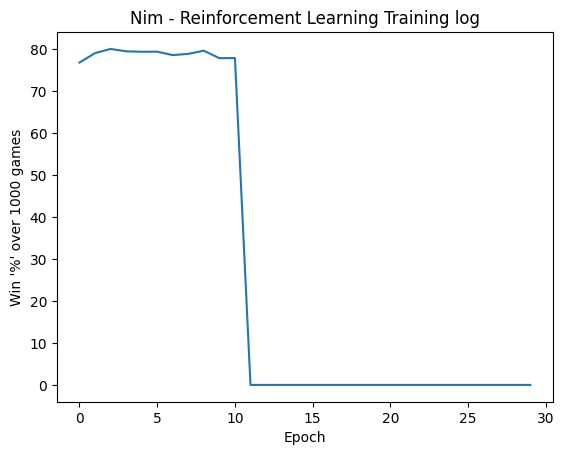

In [60]:
import matplotlib.pyplot as plt
#learning_log = learn(q_learning)


plt.plot(range(len(learning_log)),learning_log)
plt.title("Nim - Reinforcement Learning Training log")
plt.xlabel("Epoch")
plt.ylabel("Win '%' over 1000 games")

logging.info(f"q-learning strategy vs. pure random strategy --> {evaluate(q_learning, pure_random, 5, 1000)}")
logging.info(f"q-learning strategy  vs. hard coded strategy --> {evaluate(q_learning, hard_coded(params=params_empty), 5, 1000)}")
logging.info(f"q-learning strategy  vs. nim sum strategy strategy --> {evaluate(q_learning, nim_sum_strategy, 5, 1000)}")